In [1]:
import numpy as np # to build the algorithm
import matplotlib.pyplot as plt # to visualize
from sklearn.datasets import make_circles # to generate a dataset

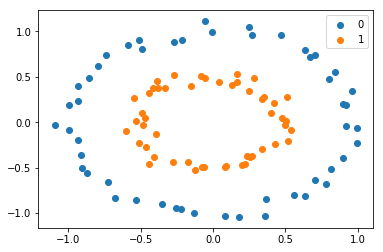

In [2]:
# Generate a dataset
X, y = make_circles(n_samples=100, noise=0.05, factor = 0.5)
plt.scatter(X[:,0][y==0], X[:,1][y==0], label=0)
plt.scatter(X[:,0][y==1], X[:,1][y==1], label=1)
plt.legend()

In [3]:
def gini_calculator(y):
    '''
    Calculates the gini impurity of a group
    y contains all the labels ie 1001110...
    gini = 1 - p1^2 - p0^2
    '''
    probs = []
    for label in np.unique(y):
        prob = len(y[y==label])/len(y)
        probs.append(prob)
    gini = 1-np.sum(np.square(np.array(probs)))
    return gini

Text(0, 0.5, 'Gini')

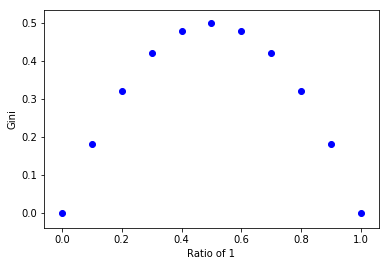

In [4]:
# Sanity check
for i in range(11):
    num_ones = i
    num_zeros = 10-i
    prop = num_ones/10
    gini = gini_calculator(np.concatenate((np.ones(num_ones), np.zeros(num_zeros))))
    plt.scatter(prop, gini, color='b')
plt.xlabel('Ratio of 1')
plt.ylabel('Gini')

In [5]:
def gini_of_a_split(y1, y2):
    '''
    Weighted average gini
    for y1 and y2
    '''
    g1 = gini_calculator(y1)
    w1 = len(y1)/(len(y1)+len(y2))
    g2 = gini_calculator(y2)
    w2 = len(y2)/(len(y1)+len(y2))
    avg_gini = g1*w1 + g2*w2
    return avg_gini

In [6]:
from operator import itemgetter

def split_finder(X, y):
    '''
    Finds the best split
    in terms of feature and its value
    that minimizes the average gini
    
    return best feature index and value
    '''
    splits = []
    for i in range(X.shape[1]):
        for Xi in X[:,i]:
            y1=y[X[:,i]<Xi]
            y2=y[X[:,i]>=Xi]
            avg_gini = gini_of_a_split(y1, y2)
            splits.append([i, Xi, avg_gini])
    
    best_split = min(splits, key=itemgetter(2))
    
    # best split rests on a datapoint
    # better if it rests in between datapoints
    # next part finds the other datapoint
    # calculates the in between split.
    
    # sorted values of feature_i
    sorted_vals_of_i = np.array(sorted(X[:,best_split[0]]))
    # calculate the other datapoint ie closest smaller value
    closest_smaller_val = sorted_vals_of_i[sorted_vals_of_i<best_split[1]][-1]
    # average to points to find the in between decision boundary
    best_split[1] = (best_split[1] + closest_smaller_val) / 2
    
    return best_split[0:2]

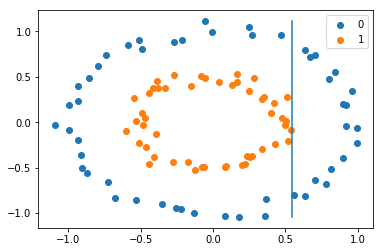

In [7]:
# Visualize the first split
best_split = split_finder(X, y)
plt.scatter(X[:,0][y==0], X[:,1][y==0], label=0)
plt.scatter(X[:,0][y==1], X[:,1][y==1], label=1)
plt.legend()

if best_split[0]==0:
    plt.plot([best_split[1],best_split[1]],[min(X[:,1]),max(X[:,1])])
elif best_split[0]==1:
    plt.plot([min(X[:,0]),max(X[:,0])],[best_split[1],best_split[1]])

In [8]:
def splitter(X, y):
    '''
    Given X and y
    calculates the best split
    returns splitted dataset and the best split
    In other words, this is one node.
    Building block of a tree.
    '''
    split = split_finder(X, y)
    X1=X[X[:,split[0]]<=split[1]]
    y1=y[X[:,split[0]]<=split[1]]
    
    X2=X[X[:,split[0]]>split[1]]
    y2=y[X[:,split[0]]>split[1]]
    
    return [X1, y1], [X2, y2], split

In [9]:
def fit_tree(X, y):
    '''
    Given X and y
    Repeat splitter to create a tree.
    return the tree i.e. the trained model
    '''
    
    max_depth = 20
    groups_in_depth = {}
    i=0
    node_name = 'root'
    first_group = [X,y]

    groups_in_depth[i] = [[first_group, node_name]]
    tree = {}

    while i<max_depth:
        # create the next depth
        groups_in_depth[i+1]=[]

        for group_n_name in groups_in_depth[i]:
            group = group_n_name[0]
            node_name = group_n_name[1]
            group1, group2, split = splitter(group[0], group[1])

            tree[node_name]={}
            tree[node_name]['feat_indx'] = split[0]
            tree[node_name]['feat_val'] = split[1]
            tree[node_name]['class_indx'] = np.bincount(group1[1]).argmax()

            group1_name = node_name + 'L'
            group2_name = node_name + 'R'


            if gini_calculator(group1[1])!=0 and len(group1[1])>3:
                groups_in_depth[i+1].append([group1, group1_name])

            if gini_calculator(group2[1])!=0 and len(group2[1])>3:
                groups_in_depth[i+1].append([group2, group2_name])


        if len(groups_in_depth[i+1])==0:break
        i=i+1
        
    return tree

In [10]:
tree = fit_tree(X,y)

In [11]:
def predict_tree(X, tree):
    '''
    Given the data and the model
    predict labels
    '''
    y_pred = []
    for i in range(len(y)):
        data_point = X[i]
        node_name = 'root'

        while node_name in tree.keys():
            if data_point[tree[node_name]['feat_indx']]<=tree[node_name]['feat_val']:
                class_indx = tree[node_name]['class_indx']
                node_name = node_name+'L'
            else:
                class_indx = 1 - tree[node_name]['class_indx']
                node_name = node_name+'R'

        y_pred.append(class_indx)
    return y_pred

In [12]:
y_pred = predict_tree(X, tree)

In [13]:
def accuracy(y_pred, y):
    return sum(y_pred==y)/len(y)

In [14]:
accuracy(y_pred, y)

1.0

In [15]:
# Putting all together
# with Train/Test
X_train, y_train = make_circles(n_samples=100, noise=0.05, factor = 0.5)
X_test, y_test = make_circles(n_samples=100, noise=0.05, factor = 0.5)
tree = fit_tree(X_train, y_train)
y_pred_train = predict_tree(X_train, tree)
y_pred_test = predict_tree(X_test, tree)

print('Training acc:', accuracy(y_pred_train, y_train))
print('Testing acc:', accuracy(y_pred_test, y_test))

Training acc: 1.0
Testing acc: 0.9


In [16]:
def fit_forest(X,y):
    '''
    Fit 30 trees
    by randomly sampling from
    X and y
    return 30 trees
    '''
    num_trees = 30
    forest = []
    for i in range(num_trees):
        idx = np.random.choice(np.arange(len(y)),int(len(y)*0.8))
        X_sample = X[idx]
        y_sample = y[idx]
        tree = fit_tree(X_sample, y_sample)
        forest.append(tree)
    return forest

In [17]:
def predict_forest(X, forest):
    '''
    Predict the labels for X
    for all 30 trees
    calculate the average of 30 trees
    return avg. predictions
    '''
    y_preds = []
    for tree in forest:
        y_pred = predict_tree(X, tree)
        y_preds.append(y_pred)
    y_preds = np.array(y_preds)
    
    y_pred = np.mean(y_preds, axis=0)
    y_pred[y_pred>0.5]=1
    y_pred[y_pred<=0.5]=0
    return y_pred

In [18]:
X_train, y_train = make_circles(n_samples=100, noise=0.05, factor = 0.5)
X_test, y_test = make_circles(n_samples=100, noise=0.05, factor = 0.5)
forest = fit_forest(X_train,y_train)
y_pred = predict_forest(X_test, forest)
accuracy(y_pred, y_test)

1.0